In [1]:
## -*- coding: utf-8 -*- 

import numpy as np
import pandas as pd

from pathlib import Path

from hbayesdm.models import ra_prospect

import nibabel as nib

from bids import BIDSLayout
from tqdm import tqdm

from sklearn.linear_model import ElasticNet, LinearRegression

from scipy.stats import zscore

import matplotlib.pyplot as plt

import nilearn as nil
from nilearn.image import resample_to_img, load_img, smooth_img
from nilearn.datasets import load_mni152_template, load_mni152_brain_mask
from nilearn.input_data import NiftiMasker
from nilearn.plotting import plot_stat_map, show

from nipy.modalities.fmri import hemodynamic_models
from nipy.modalities.fmri.hemodynamic_models import compute_regressor

import pickle

In [2]:
template = load_mni152_template()
mask = load_mni152_brain_mask()

In [3]:
# information for path, hyperparams..
DATA_DIR = '/home/mybirth0407/datasets/ds000005' # custom directory

In [4]:
layout = BIDSLayout(DATA_DIR, derivatives=True)

# if data_dir not include derivatives files
# layout.add_derivatives(DERIVATIVES_PATH)

/home/mybirth0407/anaconda3/envs/mva/lib/python3.7/site-packages/bids/layout/models.py:102: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  FutureWarning)


In [5]:
image_sample = layout.derivatives['fMRIPrep'].get(
        subject=layout.get(target='subject', return_type='id')[0],
        return_type='file',
        suffix='bold',
        extension='nii.gz')[0]

event_sample = layout.get(return_type='file', suffix='events', extension='tsv')[0]

TR = layout.get_tr()

In [6]:
masker = NiftiMasker(mask_img=mask, standardize=True)
fmri_masked = masker.fit_transform(image_sample)
print(fmri_masked.shape)

(240, 228453)


In [7]:
df_events = pd.read_table(event_sample)
df_events['respcat'] = df_events['respcat'].apply(lambda x: 1 if x == 1 else 0)
df_events['onset'] = df_events['onset'].astype(np.int)
df_events['cert'] = 0 # certain..?
df_events['gamble'] = df_events['respcat']
df_events['subjID'] = '01'
df_events['run'] = 1

columns = df_events.columns.copy() # for safety
df_events.head()

,onset,duration,parametric loss,distance from indifference,parametric gain,gain,loss,PTval,respnum,respcat,response_time,cert,gamble,subjID,run
0,0,3,0.1273,-0.0814,-0.139,20,15,5.15,0,0,0.000,0,0,01,1
1,4,3,-0.0227,-0.4147,-0.189,18,12,6.12,2,1,1.793,0,1,01,1
2,8,3,0.1273,0.2519,-0.389,10,15,-4.85,3,0,1.637,0,0,01,1
3,18,3,0.1773,-0.0814,0.211,34,16,18.16,1,1,1.316,0,1,01,1
4,24,3,-0.3727,-0.0814,-0.189,18,5,13.05,1,1,1.670,0,1,01,1


In [8]:
# model = ra_prospect(data=df_events, ncore=4)
# print(model.all_ind_pars)
# params = model.all_ind_pars
# params.to_csv('models/ra_prospect_params_sample.tsv', sep='\t', index=False)

In [9]:
params = pd.read_table('models/ra_prospect_params_sample.tsv')
params['subjID'] = params.index + 1
params['subjID'] = params['subjID'].apply(lambda x: f'{x:02d}')

In [10]:
params.head()

,rho,lambda,tau,subjID
0,1.109507,1.228393,4.907429,01


In [11]:
try: 
    df_X = pd.merge(df_events, params, how='left', on=['subjID'])
except:
    df_events.columns = columns
    df_X = pd.merge(df_events, params, how='left', on=['subjID'])

# calculate for utility risky
df_X['U_risky'] = (df_X['gain'] ** df_X['rho']) - (df_X['lambda'] * (df_X['loss'] ** df_X['rho']))

INFO:numexpr.utils:Note: detected 88 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 88 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [12]:
time_indices = np.linspace(0,
                           TR * fmri_masked.shape[0],
                           TR * TR * fmri_masked.shape[0])

/home/mybirth0407/anaconda3/envs/mva/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
df_sample = df_X[(df_X['subjID'] == '01') & (df_X['run'] == 1)]
df_sample.head()

,onset,duration,parametric loss,distance from indifference,parametric gain,gain,loss,PTval,respnum,respcat,response_time,cert,gamble,subjID,run,rho,lambda,tau,U_risky
0,0,3,0.1273,-0.0814,-0.139,20,15,5.15,0,0,0.000,0,0,01,1,1.109507,1.228393,4.907429,2.978577
1,4,3,-0.0227,-0.4147,-0.189,18,12,6.12,2,1,1.793,0,1,01,1,1.109507,1.228393,4.907429,5.351410
2,8,3,0.1273,0.2519,-0.389,10,15,-4.85,3,0,1.637,0,0,01,1,1.109507,1.228393,4.907429,-11.918829
3,18,3,0.1773,-0.0814,0.211,34,16,18.16,1,1,1.316,0,1,01,1,1.109507,1.228393,4.907429,23.398312
4,24,3,-0.3727,-0.0814,-0.189,18,5,13.05,1,1,1.670,0,1,01,1,1.109507,1.228393,4.907429,17.376403


In [14]:
exp_condition = np.array((df_sample['onset'], df_sample['duration'], df_sample['U_risky']))

<StemContainer object of 3 artists>

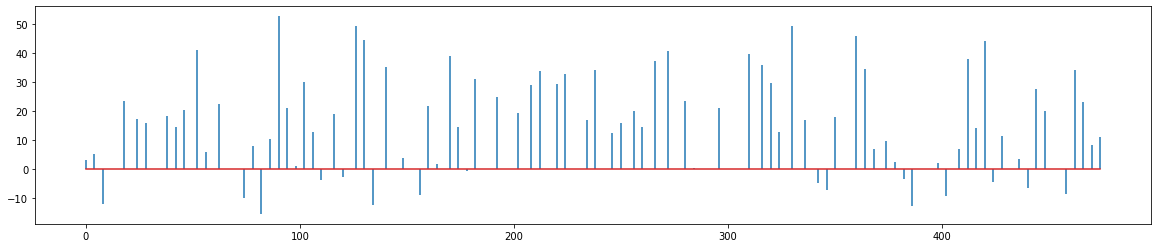

In [15]:
plt.figure(figsize=(20, 4))
plt.stem(df_sample['onset'], df_sample['U_risky'], markerfmt=' ')

In [16]:
# obtain the signal of interest by convolution
signals, _ = compute_regressor(exp_condition, 'canonical', time_indices, con_id='main')

(960, 1)


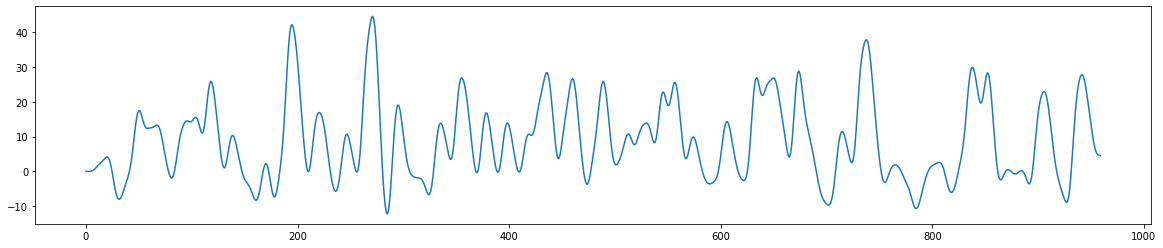

In [17]:
plt.figure(figsize=(20, 4))
print(signals.shape)
plt.plot(signals)

In [18]:
X = signals[[int(TR * TR * x) for x in range(fmri_masked.shape[0])]]

In [19]:
reg = LinearRegression()
coef_ = []
for Y in tqdm(fmri_masked.reshape(-1, 240)):
    reg.fit(X.reshape(-1, 1), Y)
    coef_.append(float(reg.coef_))

100%|██████████| 228453/228453 [00:56<00:00, 4075.82it/s]


In [20]:
coef_ = np.expand_dims(coef_, axis=0)
coef_.shape

(1, 228453)

In [21]:
print(min(coef_[0]), max(coef_[0]), np.mean(coef_[0]))

-0.04438767265822131 0.04870221181119052 1.1719360360322634e-05


In [22]:
pos_coef = coef_.copy()
coef_img = masker.inverse_transform(pos_coef)
print(coef_img)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (91, 109, 91, 1)
affine: 
[[  -2.    0.    0.   90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  4  91 109  91   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [-1.  2.  2.  2.  1.  1.  1.  1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code  

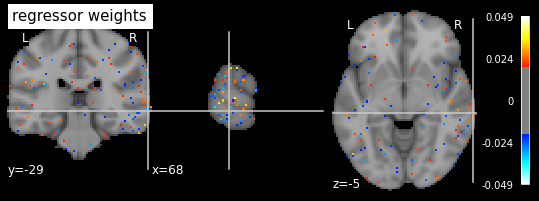

In [23]:
plot_stat_map(coef_img, bg_img=template,
              threshold=0.020,
#               cut_coords=(-23, 34, -3),
              title="regressor weights")

show()